# Configuração de Ambiente

In [1]:
path_notebook = '/content/drive/MyDrive/Competicoes_Kaggle/'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [2]:
import os
import sys
path_minhaslibs = path_notebook + 'MinhasLibs/'
sys.path.insert(0, os.path.dirname(path_minhaslibs)) 

In [3]:
import AleTransforms as trf
import AleDatasetAnalysis as dat
import AleMLAnalysis as aml
import AleExplainers as exp
import AleLearners as lrn

In [4]:
import importlib
importlib.reload(trf)
importlib.reload(dat)
importlib.reload(aml)
importlib.reload(exp)
importlib.reload(lrn)

<module 'AleLearners' from '/content/drive/MyDrive/Competicoes_Kaggle/MinhasLibs/AleLearners.py'>

In [5]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from IPython.display import clear_output
from scipy.stats import pearsonr
import gc
from multiprocessing import Pool

In [6]:
!pip install catboost

In [7]:
from catboost import CatBoostRegressor

# Acessa API do Kaggle e Baixa os Arquivos

In [9]:
#Instala a API
!pip install kaggle

In [10]:
# Move minhas credenciais para a pasta em que a API foi instalada
!mkdir -p ~/.kaggle/ && cp -i /content/drive/MyDrive/Competicoes_Kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [11]:
#Baixa dos dados do Projeto
!kaggle competitions download -c ubiquant-market-prediction

  0% 0.00/799k [00:00<?, ?B/s]
100% 799k/799k [00:00<00:00, 54.9MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 56.7kB/s]
100% 7.50G/7.50G [02:05<00:00, 64.2MB/s]
100% 7.50G/7.50G [02:05<00:00, 64.4MB/s]
  0% 0.00/52.6k [00:00<?, ?B/s]
100% 52.6k/52.6k [00:00<00:00, 46.8MB/s]
  0% 0.00/148 [00:00<?, ?B/s]
100% 148/148 [00:00<00:00, 135kB/s]


# Carrega a Base de Treino

In [8]:
df = pd.read_csv('train.csv.zip')

In [9]:
df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,...,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,0.004936,0.284220,0.502155,-0.287932,-1.169338,-0.267310,-0.574423,-0.771869,1.012212,-1.230507,1.785726,-2.090686,0.325659,-0.877769,1.048786,0.131774,-0.349609,-1.813385,0.099226,-0.241020,1.604571,0.003637,-0.902062,0.221581,0.610063,-0.738558,...,-1.158173,0.709600,-0.031878,-1.020150,-1.291206,0.038669,0.187159,-0.680358,0.900593,-0.924766,-1.057890,-0.167062,0.000000,1.281245,0.258715,-0.237964,-0.742125,-0.324677,0.992547,0.961355,-0.025610,-0.006259,0.473603,0.040136,0.453711,-1.597790,0.301659,0.157470,0.416631,1.506131,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,-0.351726,0.846882,0.440299,0.499824,0.893144,-0.010217,-0.681523,1.254092,-1.026969,-1.690156,0.011152,0.875251,0.325659,-0.458305,-1.797581,-0.300364,0.584786,0.551460,0.806422,1.235012,-0.984701,-1.084491,3.161929,0.211016,-2.656093,-0.176984,...,-0.767070,-0.015459,-0.158329,0.980246,0.799270,0.798399,-0.633207,0.779735,0.171233,1.165891,0.590802,0.118520,0.000000,-0.650803,0.851905,0.086198,1.135668,0.298990,-1.583445,-0.481945,0.532229,0.226693,-0.894744,-0.514552,-1.000073,0.884377,-0.557502,-0.875265,-0.156106,0.537055,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,0.465096,0.150847,-0.044009,0.091257,-1.169338,-0.451820,-0.467322,0.095288,1.140719,-0.166894,-0.007295,-0.449418,0.325659,-0.682472,0.016262,0.026124,-0.547330,0.551460,-0.261588,-0.169659,0.857397,-0.098464,-0.860326,0.180221,0.610063,0.524984,...,1.066427,-0.528562,0.189412,-1.020150,0.169625,-0.911228,-0.222071,0.536386,-0.161757,-0.114321,0.433277,-0.207127,0.000000,0.098910,-0.725177,-0.388189,0.062644,0.260281,0.980960,0.899393,-0.315315,0.150139,0.245546,-1.429645,-1.000073,-0.033494,-0.147156,-0.087518,0.098443,-0.529027,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,0.301204,-0.015678,-0.656295,-0.150829,-1.169338,-1.121598,-0.681523,2.921973,1.179453,0.363938,0.365656,-1.478154,0.325659,0.955586,-0.105029,-0.588826,0.650101,-1.813385,-1.421967,1.526105,-0.054643,-0.345506,0.259390,0.124939,-0.478656,-0.457771,...,-1.434426,0.084240,-0.836248,-1.020150,1.272106,-0.667804,-1.452159,1.169093,-1.024947,-0.924766,1.013206,-0.324558,0.000000,-0.817650,-0.624180,0.012915,0.599156,-1.796107,-1.843759,2.927223,-0.640443,2.324936,-0.666686,-0.049966,-1.000073,-0.172537,-0.557502,-0.986692,-0.744752,0.237733,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,0.498780,-0.235516,-0.173336,0.106523,-0.138097,-0.829021,-0.826026,4.070158,0.148330,0.269455,-0.046685,0.194325,0.325659,1.933630,-1.119676,-0.585332,0.535749,0.551460,-0.771058,0.216229,0.022421,-0.924428,0.198084,0.232416,-1.567374,-0.317377,...,0.793056,-1.657286,-0.874886,0.980246,0.778769,-0.916315,-0.556130,0.925744,-1.508002,1.165891,0.941384,-0.501547,0.000000,-1.332959,-0.767390,-0.237964,0.330900,-1.465071,-0.585437,-1.314835,-

# Análise Exploratória

In [10]:
features = [f for f in df.columns if f != 'target' and f not in ['row_id', 'time_id', 'investment_id']]

### Dependência Temporal

In [11]:
(df[['time_id', 'target']].corr().iloc[0, 1], df[['time_id', 'target']].abs().corr().iloc[0, 1])

(0.009667593265207162, -0.026732521863809842)

In [12]:
df_corr_temp = pd.DataFrame(columns = ['feature', 'normalizado', 'corr'])
for f in features:
    df_corr_temp.loc[len(df_corr_temp)] = [f, 0, df[['time_id', f]].corr().iloc[0, 1]]
    df_corr_temp.loc[len(df_corr_temp)] = [f, 1, df[['time_id', f]].abs().corr().iloc[0, 1]]

df_corr_temp['corr_abs'] = df_corr_temp['corr'].abs()
df_corr_temp = df_corr_temp.sort_values('corr_abs', ascending = False).reset_index(drop = True)
df_corr_temp = df_corr_temp.drop_duplicates('feature', keep = 'first')

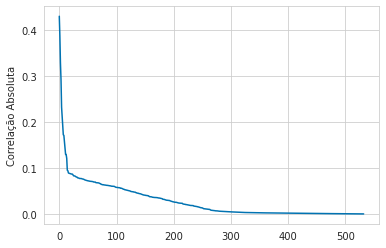

In [22]:
figsize = (6, 4)
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    ax.plot(df_corr_temp['corr_abs'], color = paleta_cores[0])
    ax.set_ylabel('Correlação Absoluta')
    plt.show()

In [74]:
df_corr_temp

,feature,normalizado,corr,corr_abs
0,f_272,0,-0.429392,0.429392
1,f_200,0,-0.386721,0.386721
2,f_170,1,0.328033,0.328033
3,f_175,0,0.292256,0.292256
4,f_22,1,0.232078,0.232078
...,...,...,...,...
436,f_164,0,-0.001669,0.001669
463,f_97,0,0.001340,0.001340
477,f_38,0,-0.001193,0.001193
512,f_131,0,-0.000835,0.000835


In [25]:
df_features_temp = df_corr_temp[df_corr_temp['corr_abs'] >= 0.09]
df_features_temp

,feature,normalizado,corr,corr_abs
0,f_272,0,-0.429392,0.429392
1,f_200,0,-0.386721,0.386721
2,f_170,1,0.328033,0.328033
3,f_175,0,0.292256,0.292256
4,f_22,1,0.232078,0.232078
7,f_182,0,-0.172247,0.172247
8,f_238,1,0.170888,0.170888
11,f_293,1,0.129707,0.129707
12,f_102,1,0.129471,0.129471
13,f_4,1,-0.120957,0.120957


In [28]:
def normalizacao_temporal(df_inp, df_features_temp):
    df = df_inp.copy()

    features = list(df_features_temp.loc[df_features_temp['normalizado'] == 1, 'feature'])
    for f in features:
        df[f + '_sign'] = np.sign(df[f].values)
        df[f] = df[f].abs()

    features = list(df_features_temp['feature'])
    df_temp = df[np.append('time_id', features)].groupby('time_id').agg(['mean', 'std'])
    df_temp.columns = [f[0] + '_' + f[1] for f in df_temp.columns]
    df_temp = df_temp.reset_index()
    df_temp['time_id'] = df_temp['time_id'] + 1
    df_fim = pd.merge(df[df['time_id'] > 0], df_temp, how = 'left', on = 'time_id')
    for f in features:
        df_fim[f] = (df_fim[f] - df_fim[f + '_mean'])/df_fim[f + '_std']

    return df_fim

In [29]:
df = normalizacao_temporal(df, df_features_temp)

In [31]:
for ind, row in df_features_temp.iterrows():
    print(df[['time_id', row['feature']]].corr().iloc[0, 1])

-0.012361756002394206
-0.010394049929355081
-0.029670751974087483
-0.010975355761466972
-0.00014672969711865177
0.07148741906859453
4.926687584401129e-05
-0.0012413014259894605
0.008688912550893282
4.701158825358142e-05
-0.016904882117340352
0.02962079115231248


# Conjuntos de Treino e Teste

In [33]:
time_ids = list(df['time_id'].value_counts().sort_index().index)

investment_ids = list(df['investment_id'].value_counts().index)
random.seed(42)
investment_ids = random.sample(investment_ids, len(investment_ids))

In [34]:
frac_teste_time = 0.1
frac_teste_investment = 0.1

In [35]:
time_ids_treino = time_ids[:int((1-frac_teste_time)*len(time_ids))]
time_ids_teste = time_ids[int((1-frac_teste_time)*len(time_ids)):]

investment_ids_treino = investment_ids[:int((1-frac_teste_investment)*len(investment_ids))]
investment_ids_teste = investment_ids[int((1-frac_teste_investment)*len(investment_ids)):]

In [36]:
mask_treino = (df['time_id'].isin(time_ids_treino) & df['investment_id'].isin(investment_ids_treino)).values

mask_teste_amostra = (df['time_id'].isin(time_ids_treino) & df['investment_id'].isin(investment_ids_teste)).values
mask_teste_tempo = (df['time_id'].isin(time_ids_teste) & df['investment_id'].isin(investment_ids_treino)).values

mask_teste = (df['time_id'].isin(time_ids_teste) & df['investment_id'].isin(investment_ids_teste)).values

In [37]:
print(np.sum(mask_treino)/df.shape[0])
print(np.sum(mask_teste_amostra)/df.shape[0])
print(np.sum(mask_teste_tempo)/df.shape[0])
print(np.sum(mask_teste)/df.shape[0])

0.7839333600497971
0.08839592270234695
0.1150468695546357
0.01262384769322024


In [38]:
print(set(time_ids_treino) & set(time_ids_teste))
print(set(investment_ids_treino) & set(investment_ids_teste))

set()
set()


# Conjuntos de Validação Cruzada

In [39]:
frac_val_time = 0.2
num_div = 4

frac_val_investment = 0.2
lista_seeds = [42, 7, 1, 12]

In [40]:
lista_time_ids_trainval = []

larg = int((1-frac_val_time)*len(time_ids_treino))
lista_ini = [int(i*(len(time_ids_treino) - larg)/num_div) for i in range(0, num_div)]
for ini in lista_ini[:-1]:
    fim = ini + larg
    time_ids_train = time_ids_treino[ini:fim]
    time_ids_val = list(np.append(time_ids_treino[:ini], time_ids_treino[fim:]))
    lista_time_ids_trainval.append((time_ids_train, time_ids_val))

ini = lista_ini[-1]
time_ids_train = time_ids_treino[ini:]
time_ids_val = time_ids_treino[:ini]
lista_time_ids_trainval.append((time_ids_train, time_ids_val))

In [41]:
lista_investiment_ids_trainval = []

for s in lista_seeds:
    random.seed(s)
    investment_ids_val = random.sample(investment_ids_treino, int(frac_val_investment*len(investment_ids_treino)))
    investment_ids_train = list(set(investment_ids_treino) - set(investment_ids_val))
    lista_investiment_ids_trainval.append((investment_ids_train, investment_ids_val))

In [42]:
lista_mask_trainval = []

for time_ids_trainval in lista_time_ids_trainval:
    for investiment_ids_trainval in lista_investiment_ids_trainval:
        mask_train = (df['time_id'].isin(time_ids_trainval[0]) & df['investment_id'].isin(investiment_ids_trainval[0])).values
        mask_val = (df['time_id'].isin(time_ids_trainval[1]) & df['investment_id'].isin(investiment_ids_trainval[1])).values
        lista_mask_trainval.append((mask_train, mask_val))

In [43]:
for time_ids_trainval in lista_time_ids_trainval:
    print(set(time_ids_trainval[0]) & set(time_ids_trainval[1]))

for investiment_ids_trainval in lista_investiment_ids_trainval:  
    print(set(investiment_ids_trainval[0]) & set(investiment_ids_trainval[1]))

set()
set()
set()
set()
set()
set()
set()
set()


In [44]:
len(lista_mask_trainval)

16

# Treinamento

In [45]:
colunas_id = ['row_id', 'time_id', 'investment_id']
alvo = 'target'

In [46]:
features = [f for f in df.columns if f not in colunas_id and f != alvo]

#### Features com Potencial de Overfitting

In [55]:
def func(x):
    return (x[0].corr().iloc[0, 1], x[1].corr().iloc[0, 1])

lista_ret = []
for f in features:
    clear_output(wait = True)
    print(f)
    with Pool(os.cpu_count()) as p:
        ret = p.map(func, [(df.loc[mask_trainval[0], [alvo, f]], df.loc[mask_trainval[1], [alvo, f]]) for mask_trainval in lista_mask_trainval])
        lista_ret.append(ret)

joblib.dump(lista_ret, f'{path_notebook}ubiquant-market-prediction/correlacoes.pkl')

f_299


['/content/drive/MyDrive/Competicoes_Kaggle/ubiquant-market-prediction/correlacoes.pkl']

In [24]:
lista_ret = joblib.load(f'{path_notebook}ubiquant-market-prediction/correlacoes.pkl')
lista_df_corr = []
for i in range(0, len(features)):
    df_corr = pd.DataFrame(lista_ret[i], columns = ['corr_train', 'corr_val']).reset_index()
    df_corr['feature'] = features[i]
    df_corr = df_corr.rename({'index': 'conj'}, axis = 1)
    df_corr = df_corr[['feature', 'conj', 'corr_train', 'corr_val']]
    lista_df_corr.append(df_corr)
df_corr = pd.concat(lista_df_corr)

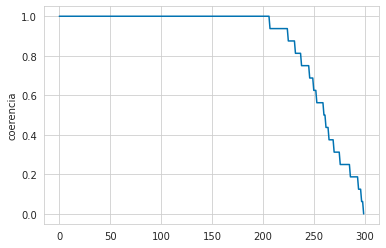

In [25]:
df_coer = df_corr.groupby('feature').apply(lambda x: pd.Series({'coerencia': np.mean(np.sign(x['corr_train']) == np.sign(x['corr_val']))}))
df_coer = df_coer.sort_values('coerencia', ascending = False).reset_index()

figsize = (6, 4)
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    ax.plot(df_coer['coerencia'], color = paleta_cores[0])
    ax.set_ylabel('coerencia')
    plt.show()

In [26]:
features_sel = list(df_coer.loc[df_coer['coerencia'] == 1, 'feature'])

In [48]:
features_sel = features

### Treinamento - ML

In [49]:
def cria_dict_avaliacao(rgs, std_train, std_val):
    d = {}
    d['melhor_iteracao'] = rgs.best_iteration_
    d['curva_treino'] = rgs.evals_result_['learn']['RMSE']
    d['curva_validacao'] = rgs.evals_result_['validation']['RMSE']
    d['desvio_treino'] = std_train
    d['desvio_validacao'] = std_val
    return d

def plot_curva_vies_variancia(aval):
    figsize = (6, 4)
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        melhor_iter = aval['melhor_iteracao']
        curva_treino = np.array(aval['curva_treino'])/aval['desvio_treino']
        curva_validacao = np.array(aval['curva_validacao'])/aval['desvio_validacao']
        ax.plot(curva_treino, color = paleta_cores[0], alpha = 1.0, label = 'Treino')
        ax.scatter(melhor_iter, curva_treino[melhor_iter], color = paleta_cores[0])
        ax.plot(curva_validacao, color = paleta_cores[1], alpha = 1.0, label = 'Validação')
        ax.scatter(melhor_iter, curva_validacao[melhor_iter], color = paleta_cores[1])
        ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
        ax.set_xlabel('Iteração')
        ax.set_ylabel('RMSE Norm.')
        plt.show()

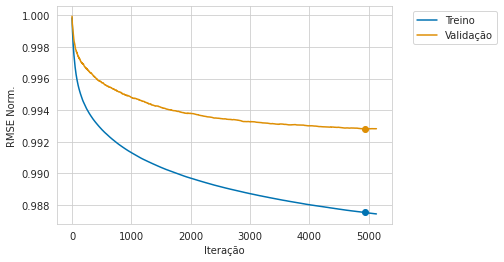

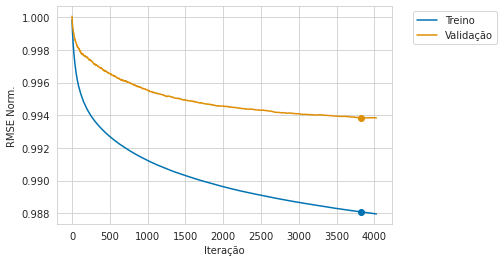

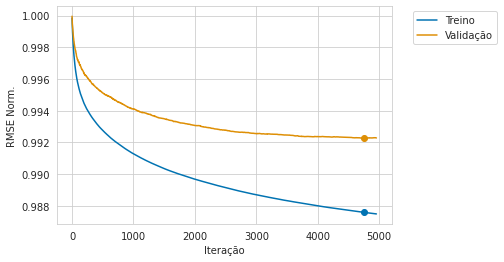

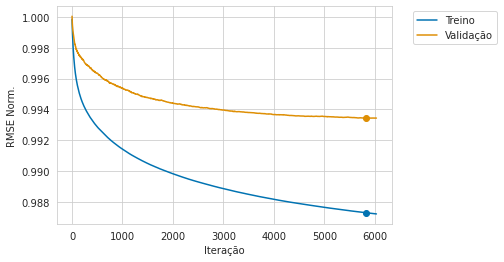

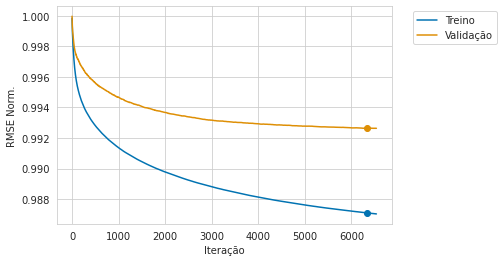

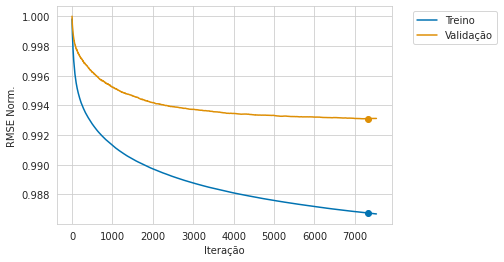

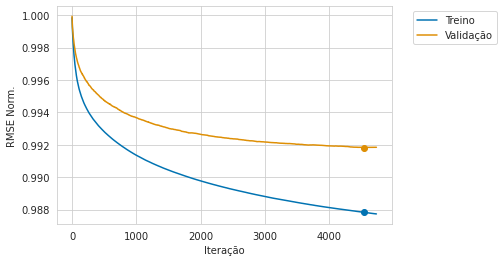

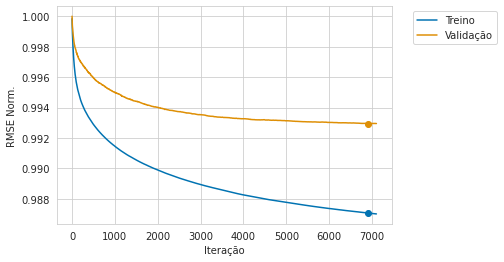

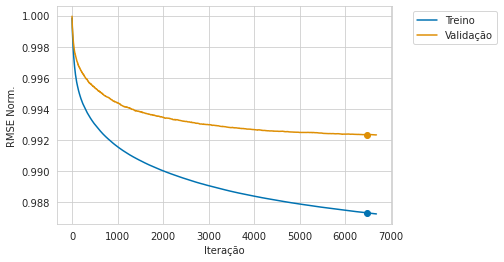

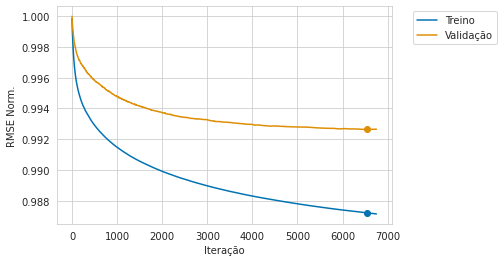

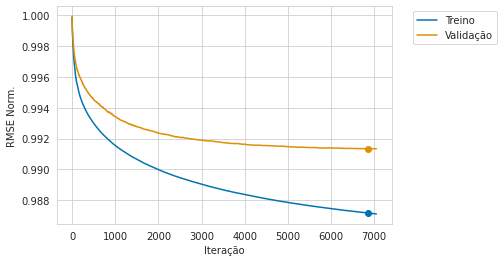

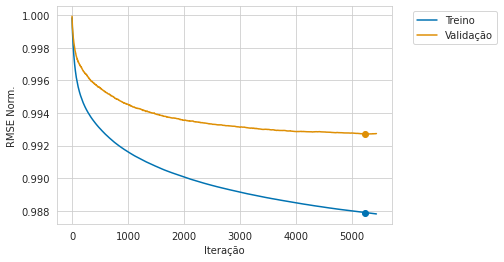

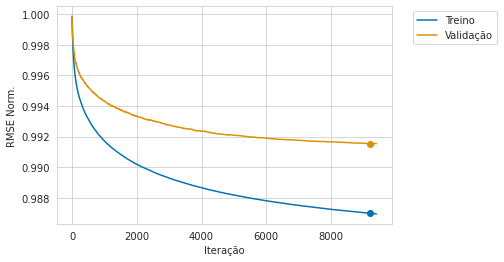

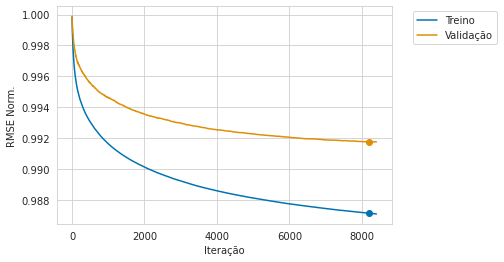

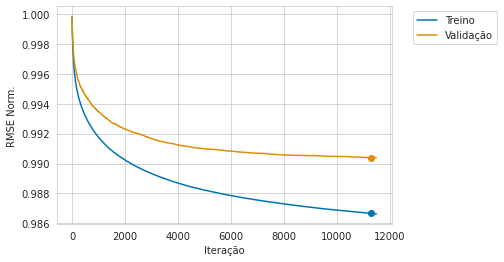

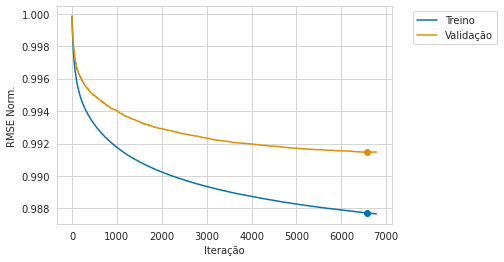

In [50]:
lista_rgs = []
lista_aval = []

for mask_trainval in lista_mask_trainval:
    mask_train = mask_trainval[0]
    mask_val = mask_trainval[1]

    gc.collect()

    rgs = CatBoostRegressor(iterations = 20000, 
                            learning_rate = 0.05, depth = 1,
                            task_type = 'GPU')

    rgs.fit(df.loc[mask_train, features_sel], df.loc[mask_train, alvo],
            eval_set = (df.loc[mask_val, features_sel], df.loc[mask_val, alvo]),
            early_stopping_rounds = 200,
            verbose = False)
    
    lista_rgs.append(rgs)

    std_train = df.loc[mask_train, alvo].std()
    std_val = df.loc[mask_val, alvo].std()
    aval = cria_dict_avaliacao(rgs, std_train, std_val)
    lista_aval.append(aval)

    plot_curva_vies_variancia(aval)

In [51]:
joblib.dump([lista_rgs, lista_aval], f'{path_notebook}ubiquant-market-prediction/regressores.pkl')

['/content/drive/MyDrive/Competicoes_Kaggle/ubiquant-market-prediction/regressores.pkl']

In [52]:
lista_rgs, lista_aval = joblib.load(f'{path_notebook}ubiquant-market-prediction/regressores.pkl')

In [53]:
class EnsembleRegressor():

    def __init__(self, lista_rgs):
        self.lista_rgs = lista_rgs
        self.feature_names_ = lista_rgs[0].feature_names_
    
    def predict(self, X):
        return np.mean(np.array([rgs.predict(X[self.feature_names_]) for rgs in self.lista_rgs]), axis = 0)

In [54]:
rgs_ens = EnsembleRegressor(lista_rgs)

In [56]:
iteracao_cv = int(round(np.mean([aval['melhor_iteracao'] for aval in lista_aval]), 0))
print(iteracao_cv)

gc.collect()

rgs = CatBoostRegressor(iterations = iteracao_cv, 
                        learning_rate = 0.05, depth = 1,
                        task_type = 'GPU')

rgs.fit(df.loc[mask_treino, features_sel], df.loc[mask_treino, alvo],
        verbose = False)

6554


In [57]:
joblib.dump(rgs, f'{path_notebook}ubiquant-market-prediction/regressor_cv.pkl')

['/content/drive/MyDrive/Competicoes_Kaggle/ubiquant-market-prediction/regressor_cv.pkl']

In [58]:
rgs = joblib.load(f'{path_notebook}ubiquant-market-prediction/regressor_cv.pkl')

In [70]:
df_imp = pd.DataFrame(zip(rgs.feature_names_, rgs.feature_importances_), columns = ['feature', 'importance'])
df_imp = df_imp.sort_values('importance', ascending = False).reset_index(drop = True)
df_imp[:50]

,feature,importance
0,f_231,10.860308
1,f_179,3.428741
2,f_78,3.404171
3,f_250,2.907418
4,f_225,2.612874
5,f_119,2.460217
6,f_21,2.154654
7,f_174,1.861491
8,f_118,1.729290
9,f_221,1.616394


# Avaliação

In [59]:
df_aval = df[['row_id', 'time_id', 'investment_id', 'target']].copy()

In [60]:
df_aval['conj'] = np.nan

df_aval.loc[mask_treino, 'conj'] = 'Treino'
df_aval.loc[mask_teste_amostra, 'conj'] = 'Teste_Amostra'
df_aval.loc[mask_teste_tempo, 'conj'] = 'Teste_Tempo'
df_aval.loc[mask_teste, 'conj'] = 'Teste'

In [61]:
def predict_batch(df, rgs, mask, particoes = 100):
    features = rgs.feature_names_
    mask_splits = np.array_split(mask.nonzero()[0], particoes)
    lista_pred = []
    i = 0
    for inds in mask_splits:
        clear_output(wait = True)
        print(f'{str(i)} / {str(particoes)}')
        i = i + 1
        lista_pred.append(rgs.predict(df.iloc[inds][features]))
    return np.concatenate(lista_pred)

In [63]:
df_aval['pred'] = np.nan

rgs_aval = rgs #rgs #rgs_ens
particoes = 10

df_aval.loc[mask_treino, 'pred'] = predict_batch(df, rgs_aval, mask_treino, particoes = particoes)
df_aval.loc[mask_teste_amostra, 'pred'] = predict_batch(df, rgs_aval, mask_teste_amostra, particoes = particoes)
df_aval.loc[mask_teste_tempo, 'pred'] = predict_batch(df, rgs_aval, mask_teste_tempo, particoes = particoes)
df_aval.loc[mask_teste, 'pred'] = predict_batch(df, rgs_aval, mask_teste, particoes = particoes)

9 / 10


In [64]:
def metricas(x):
    d = {}
    d['correlacao_media'] = np.mean(x.groupby('time_id').apply(lambda y: pd.Series({'correlacao': pearsonr(y[alvo], y['pred'])[0]}))['correlacao'])
    return pd.Series(d)

In [65]:
df_aval.groupby('conj').apply(lambda x: metricas(x))

,correlacao_media
conj,
Teste,0.117228
Teste_Amostra,0.146382
Teste_Tempo,0.110524
Treino,0.150805
